# Writing a Perceptron classifier from scratch

The Perceptron is a simple classification algorithm suitable for problems in which classes are linearly separable in feature space. Let's code a Perceptron classifier from scratch, in Python.

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from pprint import pprint

plt.style.use("fivethirtyeight")
%matplotlib inline

## Import and prepare dataset

In [2]:
# Generate a dataset with two classes using a binary one-hot encoding scheme
features, labels = make_blobs(n_samples=1500, n_features=2, centers=2, random_state=0) # random state fixed for reproducible output
print("Input dataset has: {} samples, {} features, and {} labels".format(features.shape[0], features.shape[1], np.size(np.unique(labels))))
print(features.shape)
pprint(labels[:10])

Input dataset has: 1000 samples, 2 features, and 2 labels
(1000, 2)
array([0, 0, 0, 1, 1, 0, 1, 0, 0, 1])


## Perform simple exploratory data analysis

The data science workflow consists of several logical steps, one of which is the exploration of the input dataset. This step is also referred to as exploratory data analysis (EDA) and involves investigating the patterns and modes of variability in the data. For example, scatter plots are useful for quick determinations of the linear separability of the input dataset, or for graphical determinations of the strength and direction of the linear relationship between two features. Visualization-based EDA may reveal interesting relationships between features that can provide insight into what other investigations (e.g., principal component analysis) could be performed.

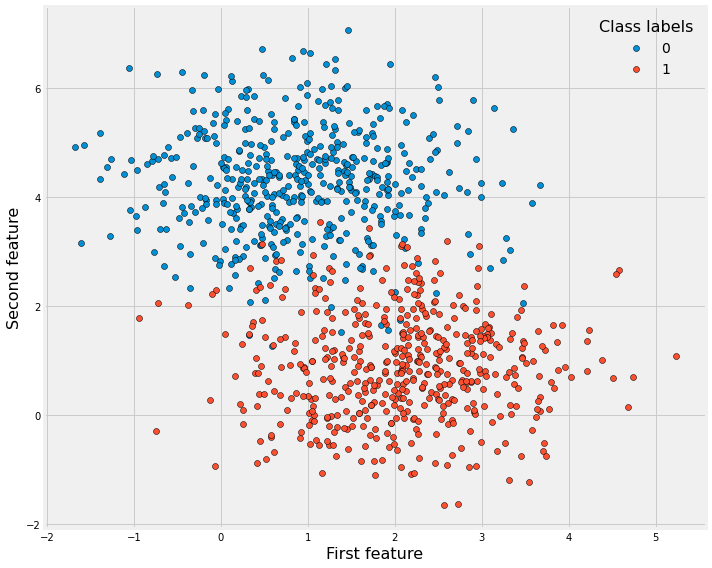

In [3]:
# Visualize relationship between features in 2-D space
fig, ax = plt.subplots(figsize=(10, 8))
for label_val in np.unique(labels):
    ax.scatter(features[labels==label_val,0], features[labels==label_val,1], marker="o", edgecolors="k", label=label_val)
ax.set_xlabel("First feature", fontsize=16)
ax.set_ylabel("Second feature", fontsize=16)
ax.legend(loc="upper right", fontsize=14, frameon=False, title="Class labels", title_fontsize=16)
plt.tight_layout()
plt.show()

## Do train-test split of inputs

In [4]:
# Split input data into training data (75%) and testing data (25%)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.25)
print(features.shape[0])
print(features_train.shape[0], features_test.shape[0])

1000
750 250


## Code up Perceptron classification algorithm

A Perceptron algorithm fits a linear model with coefficients to build a hyperplane separating data points of the observed classes in the training dataset. Let's create a Perceptron that handles binary classification problems (or tasks). If the number of features is two, the equation of the separating line is: Ax + By + C = 0, where x and y are the selected features, and A, B, and C are the unknown coefficients (A and B are feature weights, whereas C is a constant).

In [5]:
def perceptron_algorithm(features, labels, n_iter=None, learn_r=None, solver=None):
    # Set the default parameters of the model
    if n_iter == None:
        n_iter = 1000 # number of passes over the training data (aka epochs)
    if learn_r == None:
        learn_r = 0.1 # constant learning rate (must be between 0 and 1)
        
    # Specify the numerical solver to be used in the algorithm (i.e., the way to train the model)
    # It must be one of "angle" or "SGD"
    # The “angle” solver relies on vector addition/subtraction
    # The solver “SGD” uses Stochastic Gradient Descent
    if solver == None:
        solver = "angle" # if none is given, "angle" will be used
        
    # Seed the random generator, and return 3 random values between 0 and 1
    np.random.seed(1) # random state fixed for reproducible output
    nums_rand = np.random.rand(3)
    # Initialize the coefficients to small random values
    A, B, C = nums_rand[0], nums_rand[1], nums_rand[2]
    
    # Add (subtract) the feature vector to (from) the coefficient vector
    if solver == "angle":
        # Perform specified number of epochs of solver on given samples
        for _ in range(n_iter):
            # Choose a random sample from the training data
            idx_rand = np.random.randint(0, np.size(features, 0))
            x_rand, y_rand, xy_rand_label = features[idx_rand,0], features[idx_rand,1], labels[idx_rand]
            # Predict the class
            xy_pred_label = A*x_rand + B*y_rand + C
            # Update model (i.e., adjust coefficients) only on mistakes
            if xy_rand_label == 0 and xy_pred_label >= 0:
                # Increase the angle between the coefficient and feature vectors
                A -= learn_r*x_rand
                B -= learn_r*y_rand
                C -= learn_r
            elif xy_rand_label == 1 and xy_pred_label < 0:
                # Decrease the angle between the coefficient and feature vectors
                A += learn_r*x_rand
                B += learn_r*y_rand
                C += learn_r
    # Fit linear model with Stochastic Gradient Descent (SGD)
    elif solver == "SGD":
        # Perform specified number of epochs of solver on given samples
        for _ in range(n_iter):
            # Iterate over the samples from the training data
            for idx_sampl in range(np.size(features, 0)):
                x_sampl, y_sampl, xy_sampl_label = features[idx_sampl,0], features[idx_sampl,1], labels[idx_sampl]
                # Predict the class
                xy_pred_label = A*x_sampl + B*y_sampl + C
                if xy_pred_label >= 0:
                    xy_pred_label = 1
                else:
                    xy_pred_label = 0
                # Calculate and minimize the training error
                error = xy_sampl_label - xy_pred_label
                A += learn_r*error*x_sampl
                B += learn_r*error*y_sampl
                C += learn_r*error
                
    return A, B, C

In [6]:
# -- Examples of the Perceptron algorithm in action --
# Fit the model according to the training data, and get the fitted coefficients
A1, B1, C1 = perceptron_algorithm(features_train, labels_train, n_iter=1000, learn_r=0.01, solver="angle")
print("Angle: Coefficients in decision function are: A={:.5f}, B={:.5f}, and C={:.5f}".format(A1, B1, C1))
A2, B2, C2 = perceptron_algorithm(features_train, labels_train, n_iter=1000, learn_r=0.01, solver="SGD")
print("SGD: Coefficients in decision function are: A={:.5f}, B={:.5f}, and C={:.5f}".format(A2, B2, C2))

Angle: Coefficients in decision function are: A=0.01482, B=-0.06326, and C=0.12011
SGD: Coefficients in decision function are: A=0.02124, B=-0.08791, and C=0.23011


## Make predictions and compute their accuracy

Predict class labels for samples in the testing data. Then compute the fraction of correctly classified samples (i.e., the accuracy classification score).

In [7]:
def perceptron_classifier(features_sampl, labels_true, A, B, C):
    # Get predicted class label per sample
    labels_pred = A*features_sampl[:,0] + B*features_sampl[:,1] + C
    labels_pred[labels_pred>=0] = 1
    labels_pred[labels_pred<0] = 0
    # Compute the proportion of correct predictions
    bool_pred_wrt_true = labels_pred==labels_true
    score = np.sum(bool_pred_wrt_true==True)/len(bool_pred_wrt_true)
    return labels_pred, score

In [8]:
# -- Examples of the Perceptron classifier in action --
# Predict class labels for testing data points
labels_pred, score = perceptron_classifier(features_test, labels_test, A1, B1, C1)
print("Angle: Fraction of correctly classified samples is: {:.3f}".format(score))
labels_pred, score = perceptron_classifier(features_test, labels_test, A2, B2, C2)
print("SGD: Fraction of correctly classified samples is: {:.3f}".format(score))

Angle: Fraction of correctly classified samples is: 0.952
SGD: Fraction of correctly classified samples is: 0.952


## Visualize decision boundary

A decision boundary is the hyperplane separating the feature space into decision regions, in which all samples are assigned to the same class. The decision boundary of a Perceptron classifier in 2-D feature space is a line.

In [9]:
def get_m_and_b(A, B, C):
    # Transform the general form of the linear equation into the slope-intercept form (y = mx + b)
    # The general form of the linear equation (Ax + By + C = 0) can be written as a linear function of y
    # The graph of this function is a line of equation y = (-A/B)x + (-C/B)
    m = -A/B
    b = -C/B
    return m, b

In [10]:
# -- Examples of the m and b getter function in action --
# Get the slope and y-intercept of the separating line
m, b = get_m_and_b(A1, B1, C1)
print("Angle: Decision boundary is line with slope of {:.3f} and y-intercept of {:.2f}".format(m, b))
m, b = get_m_and_b(A2, B2, C2)
print("SGD: Decision boundary is line with slope of {:.3f} and y-intercept of {:.2f}".format(m, b))

Angle: Decision boundary is line with slope of 0.234 and y-intercept of 1.90
SGD: Decision boundary is line with slope of 0.242 and y-intercept of 2.62


For 1000 epochs, accuracy classification score is: 0.952
For 10000 epochs, accuracy classification score is: 0.948
For 100000 epochs, accuracy classification score is: 0.872
For 1000000 epochs, accuracy classification score is: 0.928
For 10000000 epochs, accuracy classification score is: 0.932
For 20000000 epochs, accuracy classification score is: 0.948


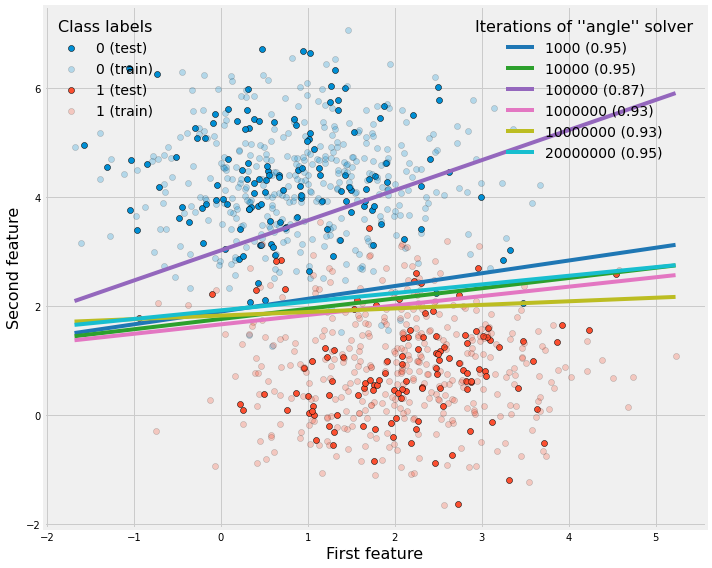

In [11]:
# Implement the "angle" solver, and adjust the number of iterations used in the algorithm
# Plot the resulting decision boundaries in 2-D feature space
coeff_score_dict1 = {}
fig, ax = plt.subplots(figsize=(10, 8))
sps = []
for label_val in np.unique(labels_train):
    sp1 = ax.scatter(features_test[labels_test==label_val,0], features_test[labels_test==label_val,1], marker="o", edgecolors="k", label="{} (test)".format(label_val))
    sp2 = ax.scatter(features_train[labels_train==label_val,0], features_train[labels_train==label_val,1], marker="o", facecolors=sp1.get_facecolor(), alpha=0.25, edgecolors="k", label="{} (train)".format(label_val))
    sps.extend((sp1, sp2))
# Find x and y values on the decision boundary
x_DB = np.linspace(np.min(features_train[:,0]), np.max(features_train[:,0]), 100)
n_iters1 = [100, 1000, 10_000, 100_000, 1_000_000]
cmap_arr = cm.get_cmap("tab10", len(n_iters1))
color_iters = cmap_arr(np.arange(cmap_arr.N))
lps = []
for n_iter, color_iter in zip(n_iters1, color_iters):
    A, B, C = perceptron_algorithm(features_train, labels_train, n_iter=n_iter, learn_r=0.01, solver="angle")
    _, score = perceptron_classifier(features_test, labels_test, A, B, C)
    coeff_score_dict1[(A, B, C)] = score
    print("For {} epochs, accuracy classification score is: {:.3f}".format(n_iter, score))
    m, b = get_m_and_b(A, B, C)
    y_DB = m*x_DB + b
    lp, = ax.plot(x_DB, y_DB, color=color_iter, linestyle="solid", label="{} ({:.2f})".format(n_iter, score))
    lps.append(lp)
ax.set_xlabel("First feature", fontsize=16)
ax.set_ylabel("Second feature", fontsize=16)
leg1 = ax.legend(handles=sps, loc="upper left", fontsize=14, frameon=False, title="Class labels", title_fontsize=16)
ax.add_artist(leg1)
leg2 = ax.legend(handles=lps, loc="upper right", fontsize=14, frameon=False, title="Iterations of ''angle'' solver", title_fontsize=16)
plt.tight_layout()
plt.show()

For 1 epochs, accuracy classification score is: 0.956
For 10 epochs, accuracy classification score is: 0.956
For 100 epochs, accuracy classification score is: 0.872
For 1000 epochs, accuracy classification score is: 0.952
For 10000 epochs, accuracy classification score is: 0.956
For 20000 epochs, accuracy classification score is: 0.828


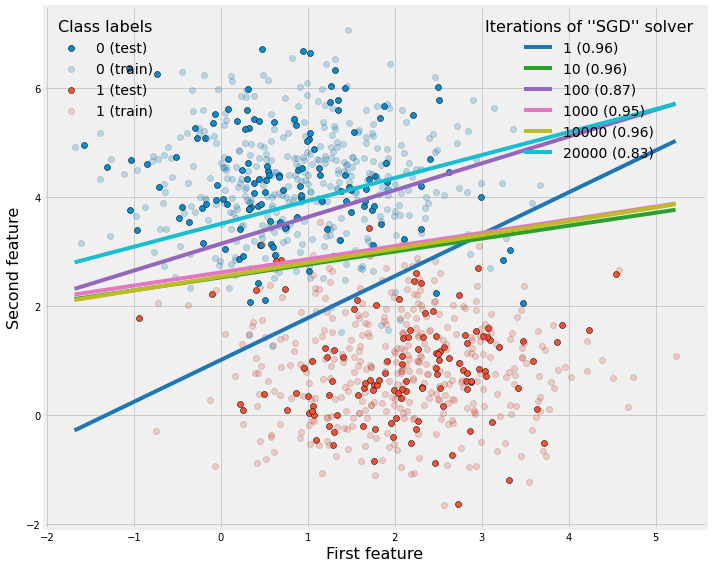

In [12]:
# Implement the "SGD" solver, and adjust the number of iterations used in the algorithm
# Plot the resulting decision boundaries in 2-D feature space
coeff_score_dict2 = {}
fig, ax = plt.subplots(figsize=(10, 8))
sps = []
for label_val in np.unique(labels_train):
    sp1 = ax.scatter(features_test[labels_test==label_val,0], features_test[labels_test==label_val,1], marker="o", edgecolors="k", label="{} (test)".format(label_val))
    sp2 = ax.scatter(features_train[labels_train==label_val,0], features_train[labels_train==label_val,1], marker="o", facecolors=sp1.get_facecolor(), alpha=0.25, edgecolors="k", label="{} (train)".format(label_val))
    sps.extend((sp1, sp2))
# Find x and y values on the decision boundary
x_DB = np.linspace(np.min(features_train[:,0]), np.max(features_train[:,0]), 100)
n_iters2 = [1, 10, 100, 1000, 10_000]
cmap_arr = cm.get_cmap("tab10", len(n_iters2))
color_iters = cmap_arr(np.arange(cmap_arr.N))
lps = []
for n_iter, color_iter in zip(n_iters2, color_iters):
    A, B, C = perceptron_algorithm(features_train, labels_train, n_iter=n_iter, learn_r=0.01, solver="SGD")
    _, score = perceptron_classifier(features_test, labels_test, A, B, C)
    coeff_score_dict2[(A, B, C)] = score
    print("For {} epochs, accuracy classification score is: {:.3f}".format(n_iter, score))
    m, b = get_m_and_b(A, B, C)
    y_DB = m*x_DB + b
    lp, = ax.plot(x_DB, y_DB, color=color_iter, linestyle="solid", label="{} ({:.2f})".format(n_iter, score))
    lps.append(lp)
ax.set_xlabel("First feature", fontsize=16)
ax.set_ylabel("Second feature", fontsize=16)
leg1 = ax.legend(handles=sps, loc="upper left", fontsize=14, frameon=False, title="Class labels", title_fontsize=16)
ax.add_artist(leg1)
leg2 = ax.legend(handles=lps, loc="upper right", fontsize=14, frameon=False, title="Iterations of ''SGD'' solver", title_fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
# Choose the set of fitted coefficients which maximizes testing accuracy
coeff_score_dict = {**coeff_score_dict1, **coeff_score_dict2}
n_iters = [*n_iters1, *n_iters2]
A, B, C = max(coeff_score_dict, key=coeff_score_dict.get)
score = coeff_score_dict[(A, B, C)]
n_iter_best = n_iters[np.argmax(list(coeff_score_dict.values()))]
print(n_iter_best, score)

1 0.956


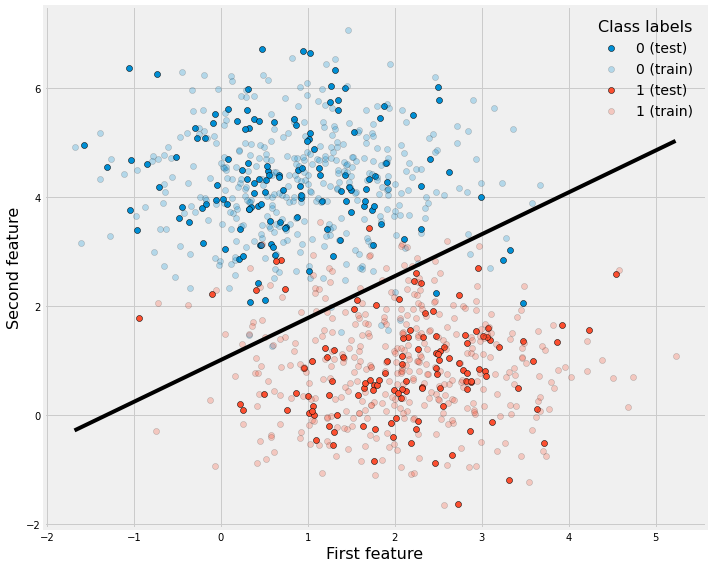

In [14]:
# Plot the "best" decision boundary over the train and test data in 2-D feature space
fig, ax = plt.subplots(figsize=(10, 8))
for label_val in np.unique(labels_train):
    sp = ax.scatter(features_test[labels_test==label_val,0], features_test[labels_test==label_val,1], marker="o", edgecolors="k", label="{} (test)".format(label_val))
    ax.scatter(features_train[labels_train==label_val,0], features_train[labels_train==label_val,1], marker="o", facecolors=sp.get_facecolor(), alpha=0.25, edgecolors="k", label="{} (train)".format(label_val))
# Find y values on the decision boundary
m, b = get_m_and_b(A, B, C)
y_DB = m*x_DB + b
ax.plot(x_DB, y_DB, color="k", linestyle="solid")
ax.set_xlabel("First feature", fontsize=16)
ax.set_ylabel("Second feature", fontsize=16)
ax.legend(loc="upper right", fontsize=14, frameon=False, title="Class labels", title_fontsize=16)
plt.tight_layout()
plt.show()

## How did we do w.r.t. scikit-learn?

Compare our homemade Perceptron classifier to some of the popular binary classifiers in the sklearn.linear_model and sklearn.svm modules.

Our Perceptron: Decision boundary is line with slope of 0.769 and y-intercept of 1.01
sklearn Perceptron: Decision boundary is line with slope of 0.321 and y-intercept of 2.74
sklearn logit regression: Decision boundary is line with slope of 0.316 and y-intercept of 2.16
sklearn SVM: Decision boundary is line with slope of 0.330 and y-intercept of 2.15


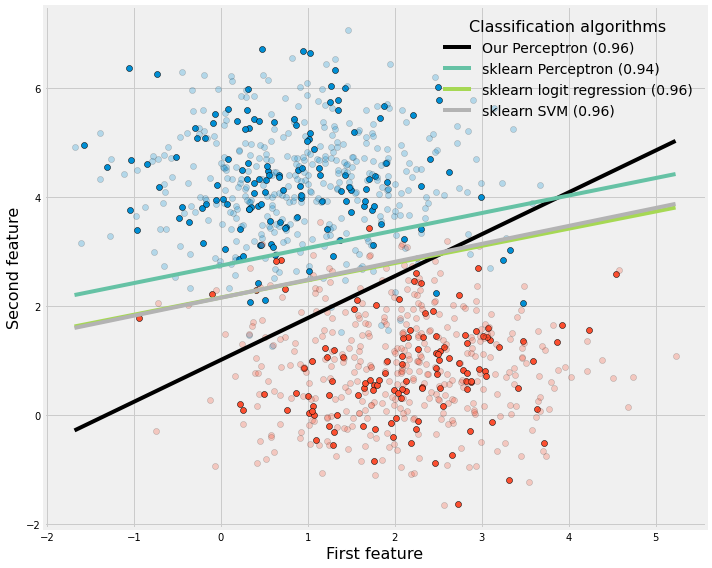

In [15]:
# Plot the decision boundary of different binary classifiers
fig, ax = plt.subplots(figsize=(10, 8))
for label_val in np.unique(labels_train):
    sp = ax.scatter(features_test[labels_test==label_val,0], features_test[labels_test==label_val,1], marker="o", edgecolors="k")
    ax.scatter(features_train[labels_train==label_val,0], features_train[labels_train==label_val,1], marker="o", facecolors=sp.get_facecolor(), alpha=0.25, edgecolors="k")
ax.plot(x_DB, y_DB, color="k", linestyle="solid", label="Our Perceptron ({:.2f})".format(score))
print("Our Perceptron: Decision boundary is line with slope of {:.3f} and y-intercept of {:.2f}".format(m, b))
# Create the sklearn classifiers
clfs = [Perceptron(max_iter=n_iter_best, tol=None, shuffle=False), LogisticRegression(), SVC(kernel="linear")]
clf_names = ["sklearn Perceptron", "sklearn logit regression", "sklearn SVM"]
cmap_arr = cm.get_cmap("Set2", len(clfs))
color_clfs = cmap_arr(np.arange(cmap_arr.N))
for clf, clf_name, color_clf in zip(clfs, clf_names, color_clfs):
    # Build the classifier from the training data
    clf.fit(features_train, labels_train)
    # Calculate the mean accuracy on the testing data
    score_skl = clf.score(features_test, labels_test)
    # Get the fitted coefficients
    weights = clf.coef_[0]
    constant = clf.intercept_[0]
    w1, w2, w0 =  weights[0], weights[1], constant
    # Get the slope and y-intercept of the separating line
    m_skl = -(w0/w2)/(w0/w1)
    b_skl = -w0/w2
    # Find y values on the decision boundary
    y_DB_skl = m_skl*x_DB + b_skl
    ax.plot(x_DB, y_DB_skl, color=color_clf, linestyle="solid", label="{} ({:.2f})".format(clf_name, score_skl))
    print("{}: Decision boundary is line with slope of {:.3f} and y-intercept of {:.2f}".format(clf_name, m_skl, b_skl))
ax.set_xlabel("First feature", fontsize=16)
ax.set_ylabel("Second feature", fontsize=16)
ax.legend(loc="upper right", fontsize=14, frameon=False, title="Classification algorithms", title_fontsize=16)
plt.tight_layout()
plt.show()